In [1]:
# Import relevant libraries
import re
import nltk
import spacy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,mean_squared_error,classification_report

In [2]:
# setting seaborn parameters/
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(6,6)})

In [3]:
# setting matplotlib parameters for better visualization of graphs
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.color':'white',
         'ytick.color':'white'
         }

plt.rcParams.update(params)
%matplotlib inline

In [4]:
#importing dataset
df=pd.read_csv("/spam_ham_dataset.csv")

In [5]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
#drop unwanted column
df.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
# check for missing values
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [9]:
# check for duplicate values
df.duplicated().sum()

178

In [10]:
# remove duplicates
df = df.drop_duplicates(keep='first')
print(df.duplicated().sum())

0


In [11]:
df.shape
# count of spam and ham emails in the data
df['label'].value_counts()

ham     3531
spam    1462
Name: label, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4993 non-null   object
 1   text       4993 non-null   object
 2   label_num  4993 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.0+ KB


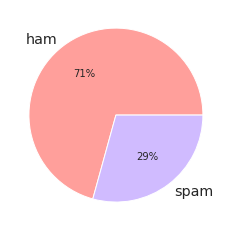

In [13]:
#create pie chart
plt.pie(df['label'].value_counts(), labels = ['ham','spam'], colors = sns.color_palette('pastel')[3:5], autopct='%.0f%%' )
plt.show()

In [14]:
# Num of characters per document
df['num_characters'] = df['text'].apply(len)

In [18]:
# text cleaning : tokenization, removal of stop words, removal of digits, removal of punctutations and lemmatization
nlp=spacy.load("en_core_web_sm")
def extraction(list_item):
    temp_list=[]
    #remove digits
    rem_digit="".join([w for w in list_item if not w.isdigit()])
    #remove punctutation
    rem_punc=re.sub('\W+',' ',rem_digit)
    #  tokenization, stop word removal, len check, lemmatization
    [temp_list.append(i.lemma_) for i in nlp(rem_punc) if not i.is_stop and len(i)>2]
    return(temp_list)

In [19]:
# calling the above extraction function
processed_emails=[]
for doc in df['text']:
        processed_emails.append(" ".join([w for w in extraction(doc)]))

In [20]:
df['transformed_text']=processed_emails

In [21]:
# conversion of text to vectors
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y= df['label_num']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [23]:
svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.973973973973974
Precision 0.9539473684210527


In [24]:
df_result=pd.DataFrame(list(zip(y_pred,y_test)),columns=['predicted_values','actual_values'])

In [25]:
df_result.head()

,predicted_values,actual_values
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


In [26]:
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.16132583806082032

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       697
           1       0.95      0.96      0.96       302

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999



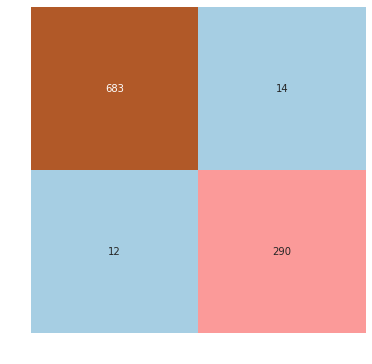

In [28]:
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam']);

In [29]:
import pickle
pickle.dump(svc,open('model.pkl','wb'))